In [95]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import math
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from gap_statistic import OptimalK

In [96]:
#Set displayed max rows 
pd.options.display.max_rows = 120

#read files
player_stats = pd.read_csv('C:\\Users\\genri\\OneDrive\\Desktop\\football\\players_stats_per_season.csv')
player_id = pd.read_csv('C:\\Users\\genri\\OneDrive\\Desktop\\football\\player_id_mapping.csv')
player_season = pd.read_csv('C:\\Users\\genri\\OneDrive\\Desktop\\football\\season_mapping.csv')
player_tournament = pd.read_csv('C:\\Users\\genri\\OneDrive\\Desktop\\football\\tournaments_mapping.csv')

In [97]:
#join player stats and seasons 
player_final = pd.merge(left = player_stats,right = player_season ,how = 'inner',left_on = 'season_id',right_on ='season_id')

#Get players only for Premier League
player_final = player_final[player_final['season_name'].str.contains("Premier League")]

In [98]:
#Join with player id table to get Name for our final table
player_final_t = pd.merge(left = player_final,right = player_id ,how = 'inner',left_on = 'player_id',right_on ='player_id')

#We are interested only in the following fields to detect the role of the player
columns = ['player_name','goals','assists','minutesPlayed','substitutionsIn','substitutionsOut','season_name','matchesStarted','appearances']
player_final_t = player_final_t[columns]

#By default all our values are zero ( based on domain knowledge) . We just need to replace N/A values with zero
player_final_t.fillna(0, inplace = True)

In [123]:
#Agreggate all our features by player
group_by = player_final_t.groupby("player_name")
checking = group_by.aggregate(['mean','max'])
checking.columns =["_".join(x) for x in checking.columns.ravel()]

#Normalize data by min-max
normalize_data=((checking-checking.min())/(checking.max()-checking.min()))

In [142]:
def K_means(data, n , return_silh = False):
    """Calculate K means for range of K

    Parameters:
    data (pandas DF): data 
    n (int):  we use range(n) to find out the most appropriate number of cluster (K)
    return_slih (boolean): Calculate or not silhouette score

    Returns:
    distortions (list): list of distortions per K - number of clusters
    silh_score (list): silhouette score for every K - cluster

    """
    distortions = []
    inertia = []
    silh_score = []
    for i in range(2, n + 1):
        X = data.to_numpy()
        kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
        if return_silh:
            silh_score.append(silhouette_score(X, kmeans.labels_, metric = 'euclidean'))
    if return_silh:
        return distortions, silh_score
    else:
        return distortions

In [133]:
kmeans = K_means(normalize_data,35)

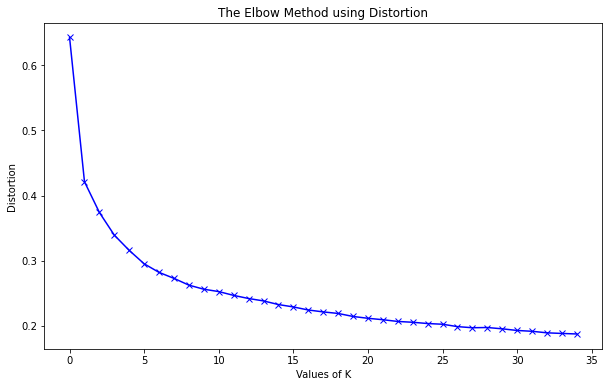

In [135]:
#Plot distortions per number of cluster
plt.figure(figsize=(10,6))
plt.plot(range(len(kmeans)), kmeans, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [163]:
#The optimum value is 8 clusters (more or less) , based on the elbow method. Anyway it's hard to detect the elbow for our data 
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
checking['label'] = kmeans.labels_

#Visualise average data for our clusters
checking.groupby("label").aggregate('mean')

,goals_mean,goals_max,assists_mean,assists_max,minutesPlayed_mean,minutesPlayed_max,substitutionsIn_mean,substitutionsIn_max,substitutionsOut_mean,substitutionsOut_max,matchesStarted_mean,matchesStarted_max,appearances_mean,appearances_max
label,,,,,,,,,,,,,,
0,3.309866,5.718310,0.440215,0.979513,1270.925975,1893.974392,4.940891,8.322663,6.539139,10.740077,14.358201,21.738796,20.713367,27.270166
1,0.263245,0.299908,0.060242,0.074176,165.535251,185.911630,1.047021,1.182692,0.331575,0.388736,1.678467,1.907967,4.044750,4.428114
2,1.026965,2.036232,0.457737,1.022645,1220.354515,1903.353261,0.832800,1.760870,0.898952,1.737319,13.628530,21.376812,17.148574,24.463768
3,2.147990,2.848970,0.037910,0.089245,61.189120,123.400458,0.121129,0.336384,0.078359,0.212815,0.580876,1.233410,20.089959,23.384439
4,0.770662,1.172694,0.173776,0.318819,648.930037,848.378598,2.906331,4.042066,1.928320,2.685609,7.056174,9.330627,11.334393,14.219188
5,2.346501,3.833944,0.937862,1.934066,2134.693030,2794.605617,0.749349,1.840049,1.415394,2.721612,24.005058,31.483516,26.168116,32.664225


In [206]:
#PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.724542  0.1118072]
0.8363492081876279


Text(0.5, 1.0, 'Clusters determined by K_means')

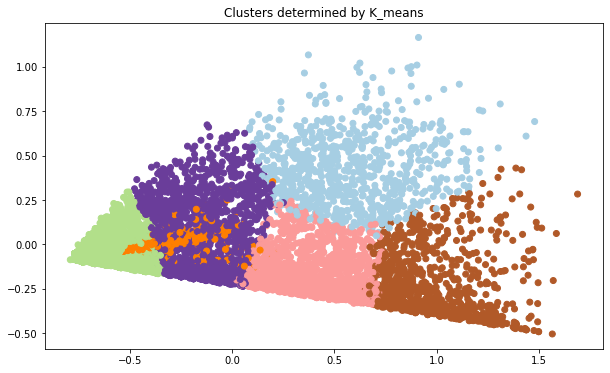

In [164]:
#Visualise our clusters by PCA 
plt.figure(figsize=(10,6))
plt.scatter(PCA_X[:,0], PCA_X[:,1],c=kmeans.predict(X), cmap='Paired')
plt.title("Clusters determined by K_means")

In [143]:
dist , silh  = K_means(normalize_data,35,True)

In [146]:
len(silh)

34

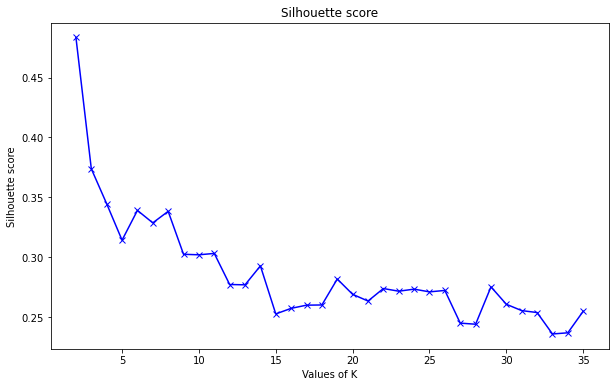

In [151]:
#Plot distortions per number of cluster
plt.figure(figsize=(10,6))
plt.plot(range(2,len(silh)+2), silh, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette score')
plt.show()

In [138]:
optimalK = OptimalK(parallel_backend='rust')
n_clusters = optimalK(X, cluster_array=np.arange(1, 25))
print('Optimal clusters: ', n_clusters)

Optimal clusters:  18


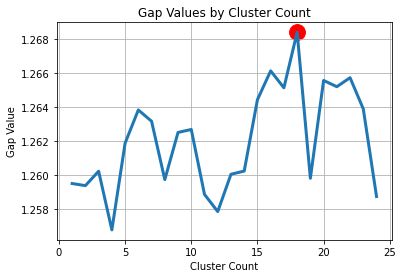

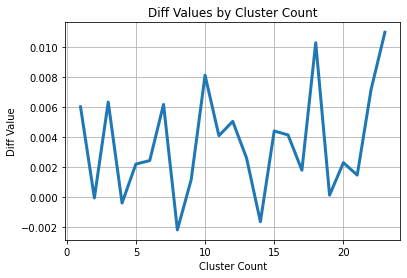

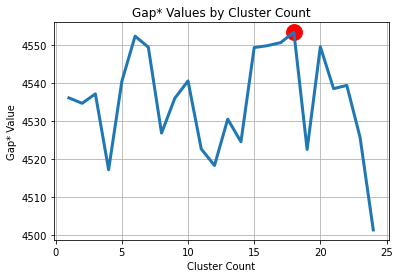

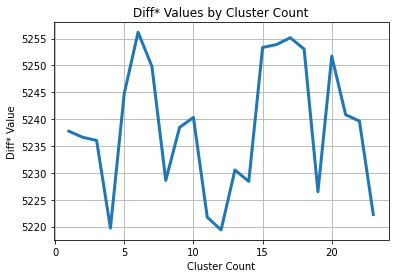

In [140]:
optimalK.plot_results()

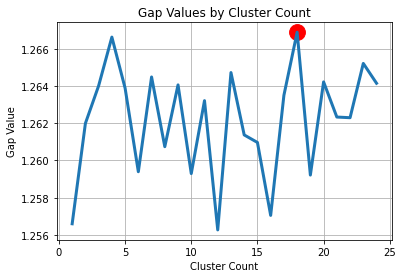

In [94]:
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [169]:
checking.loc['Jamie Vardy'].label

5.0

In [170]:
checking.groupby("label").aggregate('size') 

label
0     781
1    2184
2    1104
3     437
4    1355
5     819
dtype: int64